## Configure the sql server credentials

In [17]:
sql_server = '<input the ip of the sql server on your paper clip>'
user_name = '<input the user name of the sql server on your paper clip>'
password = "<input the password of the sql server user on your paper clip>"

## Install necessary libraries if missing

In [18]:
# PreRequisites: You have installed Revolution R Enterprise 7.5.0 or higher on the machine and SQL Server 2016 CTP3 or higher on the database server
# Install required R libraries for this walkthrough if they are not installed. 

if (!('ROCR' %in% rownames(installed.packages()))){
  install.packages('ROCR', lib='./libsforjupyter')
}
if (!('RODBC' %in% rownames(installed.packages()))){
  install.packages('RODBC', lib='./libsforjupyter')
}



In [19]:
# Add local lib directory to libPaths. The Jupyter windows user (LOCAL SERVICE) does not have write permission to global lib
.libPaths( c( .libPaths(), "./libsforjupyter") )

## Confirm that you are running under your own directory

In [20]:
# Confirm you are working in your directory named after your username
# The username is also used as prefix for DB objects you will be creating in the tutorial 
username=gsub("[^a-zA-Z0-9]", "", basename(getwd()))
username

[1] "notebooks"

## Specifying the Database Connection

* RODBC style connection string
* Compute context can be
    * Server: rx Commands will run on the server closer to the data
    * Local: Commands will run locally on the client. Data need to brought to the client. 




In [21]:
connStr <- paste("Driver=SQL Server;Server=", sql_server, ";Database=nyctaxi;Uid=", user_name, ";Pwd=", password, sep="")

# Set ComputeContext. Needs a temp directory path to serialize R objects back and forth
sqlShareDir <- paste("C:\\AllShare\\",Sys.getenv("USERNAME"),sep="")
sqlWait <- TRUE
sqlConsoleOutput <- FALSE
cc <- RxInSqlServer(connectionString = connStr, shareDir = sqlShareDir, 
                    wait = sqlWait, consoleOutput = sqlConsoleOutput)
rxSetComputeContext(cc)

## Setting up R environment to query the database

* Define a DataSource (from a select query) to be used to explore the data and generate features from.
* Keep in mind that inDataSource is just a reference to the result dataset from the SQL query.

In [22]:

sampleDataQuery <- "select tipped, tip_amount, fare_amount, passenger_count,trip_time_in_secs,trip_distance, 
pickup_datetime, dropoff_datetime, 
cast(pickup_longitude as float) as pickup_longitude, 
cast(pickup_latitude as float) as pickup_latitude, 
cast(dropoff_longitude as float) as dropoff_longitude, 
cast(dropoff_latitude as float)  as dropoff_latitude,
cast(pickup_longitude as float) * 100 as pickup_longitude2, 
cast(pickup_latitude as float) * 100 as pickup_latitude2, 
cast(dropoff_longitude as float) * 100 as dropoff_longitude2, 
cast(dropoff_latitude as float) * 100 as dropoff_latitude2,
payment_type from nyctaxi_sample
tablesample (5 percent) repeatable (98052)
"

ptypeColInfo <- list(
  payment_type = list(
    type = "factor",
    levels = c("CSH", "CRD", "DIS", "NOC", "UNK"),
    newLevels= c("CSH", "CRD", "DIS", "NOC", "UNK")
  )
)

inDataSource <- RxSqlServerData(sqlQuery = sampleDataQuery, connectionString = connStr, colInfo = ptypeColInfo,
                                colClasses = c(pickup_longitude = "numeric", pickup_latitude = "numeric", 
                                               dropoff_longitude = "numeric", dropoff_latitude = "numeric"),
                                rowsPerRead=500)


## Understand the data

These functions give you basic information about your data source, such as its size and the names of columns in the set:

- `rxGetInfo`
- `rxGetVarInfo` (same as `rxGetInfo` with `getVarInfo = TRUE`)
- `rxGetVarNames`

The `rxGetInfo` function offers information on the data location, size, number of columns, and other related information.
    
## Numerical Data Summaries

We now move to quantitative summaries of the data. The `rxSummary` command provides output on the number of observations contained in a data set and for a particular column, the function provides output on the following:

 - Name
 - Mean value
 - Standard Deviation
 - Minimum and Maximum value
 - Number of valid observations
 - Number of missing observations

The `rxSummary` function takes a formula as its first argument, and the name of the data set as the second.

In addition, column subsets and transformations may also be computed as a sub-call to the function using the transforms (and so forth) commands.

If compute context is SQL server, it is executed closer to the data. 


In [23]:

################################
#        Data exploration      #
################################
# Summarize the Sampled Data
rxGetVarInfo(data = inDataSource)
rxSummary(~fare_amount:F(passenger_count,1,6), data = inDataSource)

Var 1: tipped, Type: integer
Var 2: tip_amount, Type: numeric
Var 3: fare_amount, Type: numeric
Var 4: passenger_count, Type: integer
Var 5: trip_time_in_secs, Type: numeric, Storage: int64
Var 6: trip_distance, Type: numeric
Var 7: pickup_datetime, Type: character
Var 8: dropoff_datetime, Type: character
Var 9: pickup_longitude, Type: numeric
Var 10: pickup_latitude, Type: numeric
Var 11: dropoff_longitude, Type: numeric
Var 12: dropoff_latitude, Type: numeric
Var 13: pickup_longitude2, Type: numeric
Var 14: pickup_latitude2, Type: numeric
Var 15: dropoff_longitude2, Type: numeric
Var 16: dropoff_latitude2, Type: numeric
Var 17: payment_type, Type: factor, no factor levels available

Call:
rxSummary(formula = ~fare_amount:F(passenger_count, 1, 6), data = inDataSource)

Summary Statistics Results for: ~fare_amount:F(passenger_count, 1, 6)
Data: inDataSource (RxSqlServerData Data Source)
Number of valid observations: 85179 
 
 Name                                Mean     StdDev   Min Max ValidObs
 fare_amount:F_passenger_count_1_6_T 12.24191 9.817023 -52 300 85178   
 MissingObs
 1         

Statistics by category (6 categories):

 Category                                   F_passenger_count_1_6_T Means   
 fare_amount for F(passenger_count,1,6,T)=1 1                       12.07936
 fare_amount for F(passenger_count,1,6,T)=2 2                       12.87432
 fare_amount for F(passenger_count,1,6,T)=3 3                       12.61653
 fare_amount for F(passenger_count,1,6,T)=4 4                       12.69309
 fare_amount for F(passenger_count,1,6,T)=5 5                       12.48442
 fare_amount for F(passenger_count,1,6,T)=6 6                       12.00460
 StdDev

In [24]:
################################
#       Data Visualization     #
################################

cube1<-rxCube(tip_amount~F(passenger_count,1,6):F(trip_distance,0, 25), data = inDataSource)
cubePlot <- rxResultsDF(cube1)
cubePlot

,passenger_count,trip_distance,tip_amount,Counts
1,1,0,0.608530471219584,13603
2,2,0,0.568109756097561,2296
3,3,0,0.526256906077348,724
4,4,0,0.530420168067227,357
5,5,0,0.507468105986261,1019
6,6,0,0.487379972565158,729
7,1,1,0.87701412273207,19897
8,2,1,0.829841185812599,3778
9,3,1,0.768248540450375,1199
10,4,1,0.736566666666667,600


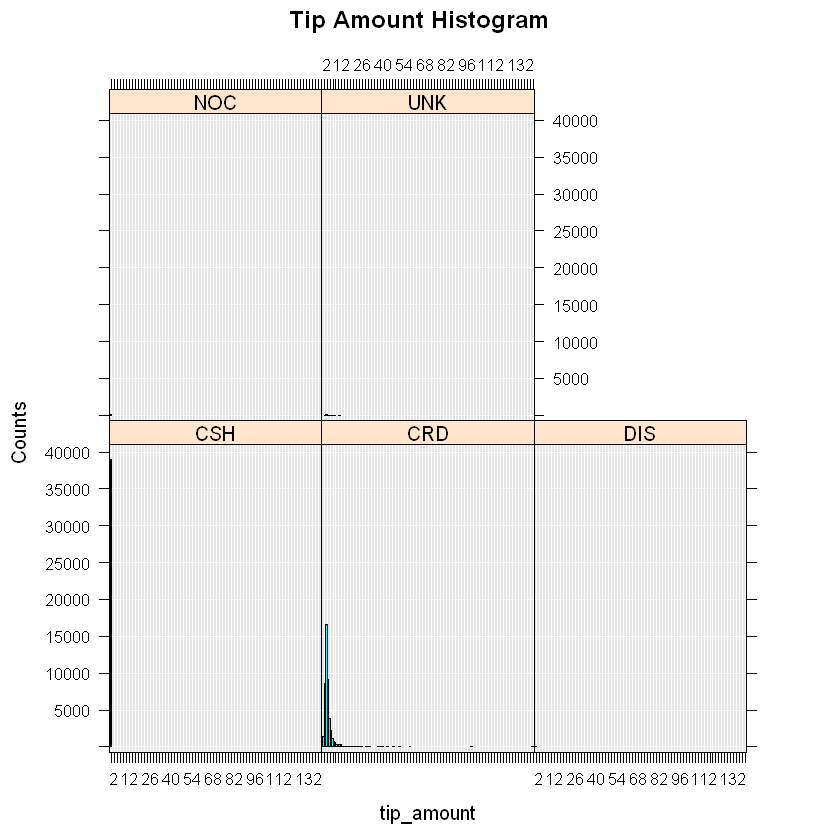

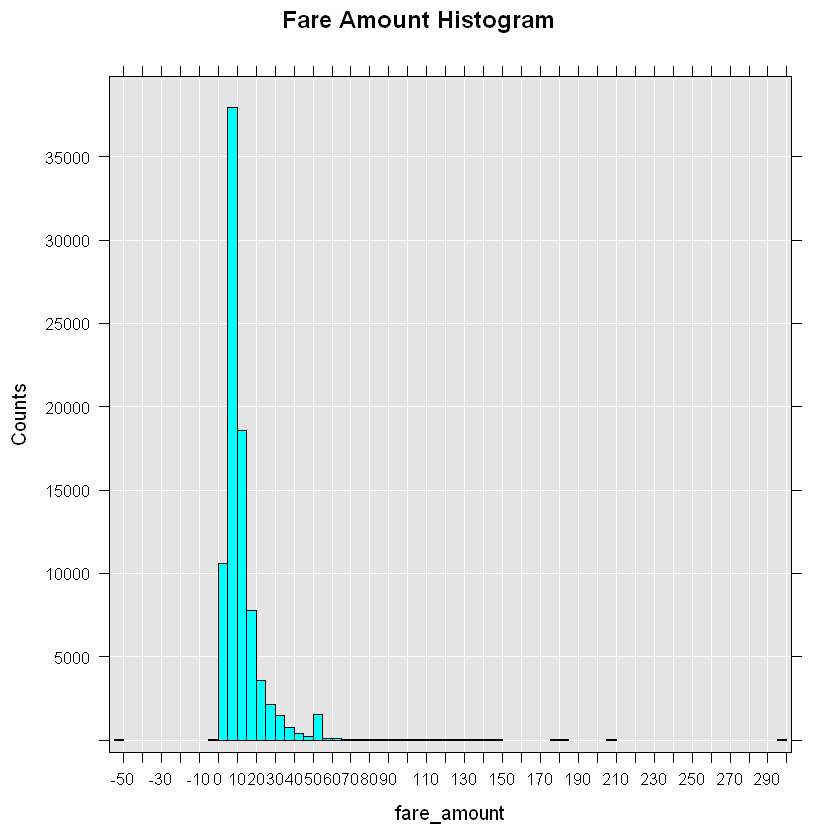

In [25]:
# Plot fare amount histogram on the SQL Server, and ship the plot to R client to display
rxHistogram(~tip_amount | payment_type, data = inDataSource, title = "Tip Amount Histogram")
rxHistogram(~fare_amount, data = inDataSource, title = "Fare Amount Histogram")

## Feature engineering

### Feature engineering using functions defined in open source R

In [26]:
# Define a function in open source R to calculate the direct distance between pickup and dropoff as a new feature 
# Use Haversine Formula: https://en.wikipedia.org/wiki/Haversine_formula
env <- new.env()

env$ComputeDist <- function(pickup_long, pickup_lat, dropoff_long, dropoff_lat){
  R <- 6371/1.609344 #radius in mile
  delta_lat <- dropoff_lat - pickup_lat
  delta_long <- dropoff_long - pickup_long
  degrees_to_radians = pi/180.0
  a1 <- sin(delta_lat/2*degrees_to_radians)
  a2 <- as.numeric(a1)^2
  a3 <- cos(pickup_lat*degrees_to_radians)
  a4 <- cos(dropoff_lat*degrees_to_radians)
  a5 <- sin(delta_long/2*degrees_to_radians)
  a6 <- as.numeric(a5)^2
  a <- a2+a3*a4*a6
  c <- 2*atan2(sqrt(a),sqrt(1-a))
  d <- R*c
  return (d)
}

featuretable = paste0(username , "_features")
#Define the featureDataSource to be used to store the features, specify types of some variables as numeric
featureDataSource = RxSqlServerData(table = featuretable, 
                                    colClasses = c(pickup_longitude = "numeric", pickup_latitude = "numeric", 
                                                   dropoff_longitude = "numeric", dropoff_latitude = "numeric",
                                                   passenger_count  = "numeric", trip_distance  = "numeric",
                                                   trip_time_in_secs  = "numeric", direct_distance  = "numeric"),
                                    connectionString = connStr)

# Create feature (direct distance) by calling rxDataStep() function, which calls the env$ComputeDist function to process records
# And output it along with other variables as features to the featureDataSource
# This will be the feature set for training machine learning models
start.time <- proc.time()
rxDataStep(inData =   inDataSource, outFile = featureDataSource,  overwrite = TRUE, 
           varsToKeep=c("tipped", "fare_amount", "passenger_count","trip_time_in_secs", 
                        "trip_distance", "pickup_datetime", "dropoff_datetime", "pickup_longitude",
                        "pickup_latitude","dropoff_longitude", "dropoff_latitude"),
           transforms = list(direct_distance=ComputeDist(pickup_longitude, pickup_latitude, dropoff_longitude, 
                                                         dropoff_latitude)),
           transformEnvir = env, rowsPerRead=10000, reportProgress = 3)
used.time <- proc.time() - start.time
print(paste("It takes CPU Time=", round(used.time[1]+used.time[2],2), 
            " seconds, Elapsed Time=", round(used.time[3],2), " seconds to generate features using R functions.", sep=""))

[1] "It takes CPU Time=0.74 seconds, Elapsed Time=10.39 seconds to generate features using R functions."


### Feature engineering by calling a stored procedure in SQL Server

In [34]:
# Do feature engineering through a SQL Query

ptypeColInfo <- list(
  payment_type = list(
    type = "factor",
    levels = c("CSH", "CRD", "DIS", "NOC", "UNK"),
    newLevels= c("CSH", "CRD", "DIS", "NOC", "UNK")
  )
)
# Alternatively, use a user defined function in SQL to create features
# Sometimes, feature engineering in SQL might be faster than R
# You need to choose the most efficient way based on real situation
# Here, featureEngineeringQuery is just a reference to the result from a SQL query. 
featureEngineeringQuery = "SELECT tipped, fare_amount, passenger_count,trip_time_in_secs,trip_distance, 
pickup_datetime, dropoff_datetime, 
dbo.fnCalculateDistance(pickup_latitude, pickup_longitude,  dropoff_latitude, dropoff_longitude) as direct_distance,
pickup_latitude, pickup_longitude,  dropoff_latitude, dropoff_longitude, payment_type
FROM nyctaxi_sample
tablesample (70 percent) repeatable (98052)
"
featureDataSource = RxSqlServerData(sqlQuery = featureEngineeringQuery, colInfo = ptypeColInfo,
                                    colClasses = c(pickup_longitude = "numeric", pickup_latitude = "numeric", 
                                                   dropoff_longitude = "numeric", dropoff_latitude = "numeric",
                                                   passenger_count  = "numeric", trip_distance  = "numeric",
                                                   trip_time_in_secs  = "numeric", direct_distance  = "numeric", fare_amount="numeric"),
                                    connectionString = connStr)

# summarize the feature table after the feature set is created
rxGetVarInfo(data = featureDataSource)

Var 1: tipped, Type: integer
Var 2: fare_amount, Type: numeric
Var 3: passenger_count, Type: numeric
Var 4: trip_time_in_secs, Type: numeric
Var 5: trip_distance, Type: numeric
Var 6: pickup_datetime, Type: character
Var 7: dropoff_datetime, Type: character
Var 8: direct_distance, Type: numeric
Var 9: pickup_latitude, Type: numeric
Var 10: pickup_longitude, Type: numeric
Var 11: dropoff_latitude, Type: numeric
Var 12: dropoff_longitude, Type: numeric
Var 13: payment_type, Type: factor, no factor levels available

## Train logistic regression models to predict tipped or not (binary classification)

In [35]:
################################
#        Training models       #
################################
# build classification model to predict tipped or not
system.time(logitObj <- rxLogit(tipped ~  passenger_count + trip_distance + trip_time_in_secs + direct_distance, data = featureDataSource))
summary(logitObj)

   user  system elapsed 
   0.26    0.00   17.97 

Call:
rxLogit(formula = tipped ~ passenger_count + trip_distance + 
    trip_time_in_secs + direct_distance, data = featureDataSource)

Logistic Regression Results for: tipped ~ passenger_count +
    trip_distance + trip_time_in_secs + direct_distance
Data: featureDataSource (RxSqlServerData Data Source)
Dependent variable(s): tipped
Total independent variables: 5 
Number of valid observations: 1192336
Number of missing observations: 0 
-2*LogLikelihood: 1648150.7753 (Residual deviance on 1192331 degrees of freedom)
 
Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)        1.153e-01  3.349e-03  34.425 2.22e-16 ***
passenger_count   -3.207e-02  1.329e-03 -24.129 2.22e-16 ***
trip_distance     -1.223e-07  2.473e-07  -0.495    0.621    
trip_time_in_secs  2.604e-08  9.403e-08   0.277    0.782    
direct_distance    1.678e-02  7.895e-04  21.256 2.22e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Condition number of final va

## Make predictions using the trained logistic regression model

In [36]:
# predict and write the prediction results back to SQL Server table
outputtable = paste0(username,"_scoreoutput")
scoredOutput <- RxSqlServerData(
  connectionString = connStr,
  table = outputtable
)

rxPredict(modelObject = logitObj, data = featureDataSource, outData = scoredOutput, 
          predVarNames = "Score", type = "response", writeModelVars = TRUE, overwrite = TRUE)

RxSqlServerData Source
table: notebooks_scoreoutput
useFastRead: TRUE
connectionString: Driver=SQL Server;Server=52.225.131.44;Database=nyctaxi;Uid=sqluser24342;Pwd=Kdd17@Halifax_24923

## Evaluate the model

Rows Read: 101, Total Rows Processed: 101, Total Chunk Time: 0.062 seconds 


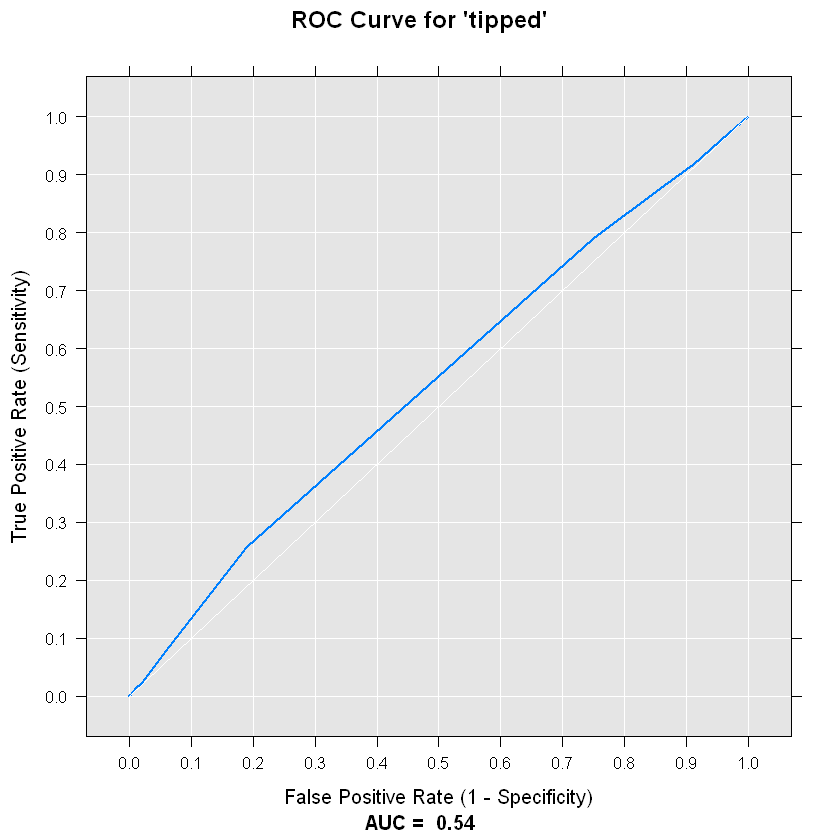

In [37]:
# plot ROC curve from SQL Context
rxRocCurve( "tipped", "Score", scoredOutput)

## Persist (operationalize) the model as a record in the database

In [38]:
################################
#   Model operationalization   #
################################
# First, serialize a model and put it into a database table
modelbin <- serialize(logitObj, NULL)
modelbinstr=paste(modelbin, collapse="")

library(RODBC)
conn <- odbcDriverConnect(connStr )

# Persist model by calling a stored procedure from SQL
q<-paste("EXEC PersistModel @m='", modelbinstr,"', @modeler='", user_name, "'", sep="")
sqlQuery (conn, q)

character(0)

## Consume the model persisted in database through stored procedure execution

### Request-Response mode

In [49]:
# Consume Model through Stored Proc Execution
# There are two stored Procs - One for predicting on single observation and another for predicting a batch of observations

# Single Observation prediction
q = paste("EXEC PredictTipSingleMode @passenger_count=1, @trip_distance=2.5, @trip_time_in_secs=631, 
     @pickup_latitude=40.763958,@pickup_longitude=-73.973373, @dropoff_latitude=40.782139,@dropoff_longitude=-73.977303,
     @modeler='", user_name, "'", sep="")
sqlQuery (conn, q)

q = paste("EXEC PredictTipSingleMode @passenger_count=9, @trip_distance=100, @trip_time_in_secs=5214, 
@pickup_latitude=40.75984, @pickup_longitude=-73.9754, @dropoff_latitude=41.0496, @dropoff_longitude=-73.54097,
@modeler='", user_name, "'", sep="")
sqlQuery (conn, q)

,Score
1,1


,Score
1,0


### Batch mode

In [56]:
# Batch mode prediction. Score all data that were not part of the training dataset and select top 10 to preedict
input = "N'select top 3 a.passenger_count as passenger_count, 
	a.trip_time_in_secs as trip_time_in_secs,
	a.trip_distance as trip_distance,
	a.dropoff_datetime as dropoff_datetime,  
	dbo.fnCalculateDistance(pickup_latitude, pickup_longitude, dropoff_latitude,dropoff_longitude) as direct_distance , fare_amount, payment_type
from
(
	select medallion, hack_license, pickup_datetime, passenger_count,trip_time_in_secs,trip_distance,  
		dropoff_datetime, pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude, fare_amount, payment_type
	from nyctaxi_sample
)a
left outer join
(
select medallion, hack_license, pickup_datetime
from nyctaxi_sample
tablesample (70 percent) repeatable (98052)
)b
on a.medallion=b.medallion and a.hack_license=b.hack_license and a.pickup_datetime=b.pickup_datetime
where b.medallion is null
'"
q<-paste("EXEC PredictTipBatchMode @inquery = ", input, ", @modeler='", user_name, "'",sep="")
sqlQuery (conn, q)

,Score
1,1
2,1
3,1
